In [1]:
import os, shutil
import numpy as np

from matplotlib import image, pyplot
from skimage.transform import resize


from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, f1_score, recall_score,classification_report,roc_curve, auc 
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm


In [2]:
!wget --no-check-certificate http://www.cs.northwestern.edu/~yga751/ML/SpamImages.zip
!wget --no-check-certificate http://www.cs.northwestern.edu/~yga751/ML/NaturalImages.zip

--2021-10-17 13:58:02--  http://www.cs.northwestern.edu/~yga751/ML/SpamImages.zip
Resolving www.cs.northwestern.edu (www.cs.northwestern.edu)... 165.124.180.20
Connecting to www.cs.northwestern.edu (www.cs.northwestern.edu)|165.124.180.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://users.cs.northwestern.edu/~yga751/ML/SpamImages.zip [following]
--2021-10-17 13:58:02--  http://users.cs.northwestern.edu/~yga751/ML/SpamImages.zip
Resolving users.cs.northwestern.edu (users.cs.northwestern.edu)... 165.124.180.20
Reusing existing connection to www.cs.northwestern.edu:80.
HTTP request sent, awaiting response... 302 Found
Location: https://users.cs.northwestern.edu/~yga751/ML/SpamImages.zip [following]
--2021-10-17 13:58:03--  https://users.cs.northwestern.edu/~yga751/ML/SpamImages.zip
Connecting to users.cs.northwestern.edu (users.cs.northwestern.edu)|165.124.180.20|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent

In [ ]:
!mkdir "Dataset"
!unzip NaturalImages.zip -d "/Dataset"
!unzip SpamImages.zip -d "/Dataset"

In [4]:
resultPath = '/Dataset'
DATA_PATH = '/Dataset'
# train_folder = os.listdir().remove("New_Spam")

In [5]:
DATA_PATH = '/Dataset/'
spamData=[]
label=[]
hashList=[]
count=-1
for folder in os.listdir(DATA_PATH):
    if folder=="New_Spam":
      continue;
    print(">>>Reading ",folder)
    count+=1
    
    try:
        for file in os.listdir(DATA_PATH+folder):
            try:
                if(str(file).endswith('.jpg') or str(file).endswith('.JPG') or str(file).endswith('.jpeg') or str(file).endswith('.JPEG')):
                    img = image.imread(DATA_PATH+folder+'/'+file)
                    hsh = hash(tuple(np.array(img).flatten()))
                    if(hsh not in hashList):
                        spamData.append(resize(img, (156, 156, 3)))
                        hashList.append(hsh)
                        label.append(count)
            except:
                pass
    except:
        pass


>>>Reading  SpamImages
>>>Reading  NaturalImages


In [6]:
spamData=np.array(spamData)
label=np.array(label)
# print(label[label==1])
print("Number of SPAM",len(label[label==0]))
print("Number of HAM",len(label[label==1]))

Number of SPAM 897
Number of HAM 810


In [7]:
print("Spam data shape : ",spamData.shape," Label shape : ",label.shape)

Spam data shape :  (1707, 156, 156, 3)  Label shape :  (1707,)


In [8]:
test_valid_Percentage = 0.3
x_train,x_test,y_train,y_test = train_test_split(spamData,label,test_size = test_valid_Percentage,random_state=42, stratify=label,shuffle=True)

In [9]:
print("x_train shape : ",x_train.shape," y_train shape : ",y_train.shape)
print("x_test shape : ",x_test.shape," y_test shape : ",y_test.shape)

x_train shape :  (1194, 156, 156, 3)  y_train shape :  (1194,)
x_test shape :  (513, 156, 156, 3)  y_test shape :  (513,)


In [10]:
print("Number of train SPAM",len(y_train[y_train==0]))
print("Number of train HAM",len(y_train[y_train==1]))

print("Number of test SPAM",len(y_test[y_test==0]))
print("Number of test HAM",len(y_test[y_test==1]))

Number of train SPAM 627
Number of train HAM 567
Number of test SPAM 270
Number of test HAM 243


In [11]:
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

print("y_train_oh shape : ",y_train_oh.shape," y_test_oh shape : ",y_test_oh.shape)

y_train_oh shape :  (1194, 2)  y_test_oh shape :  (513, 2)


In [12]:
NO_OF_EPOCHS=100
BATCH_SIZE=32

model=Sequential()
model.add(Conv2D(32,kernel_size=3, padding='same',activation='relu',input_shape=(156, 156,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size=3, padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128,kernel_size=3, padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 156, 156, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 39, 39, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 194688)            0

In [14]:
checkpointer = callbacks.ModelCheckpoint(filepath=resultPath+"/checkpoint-{epoch:04d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger(resultPath+'/result_logger.csv',separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=2, min_lr=0.001)
model.fit(x_train,y_train,epochs=NO_OF_EPOCHS,verbose=1,batch_size=BATCH_SIZE,validation_data=(x_test,y_test),callbacks=[checkpointer,csv_logger,reduce_lr])

Epoch 1/100
38/38 [==============================] - 4s 94ms/step - loss: 1.0667 - accuracy: 0.8049 - val_loss: 0.2113 - val_accuracy: 0.9162
Epoch 2/100
38/38 [==============================] - 3s 74ms/step - loss: 0.1900 - accuracy: 0.9389 - val_loss: 0.1311 - val_accuracy: 0.9630
Epoch 3/100
38/38 [==============================] - 3s 74ms/step - loss: 0.2455 - accuracy: 0.9188 - val_loss: 0.1382 - val_accuracy: 0.9532
Epoch 4/100
38/38 [==============================] - 3s 74ms/step - loss: 0.1643 - accuracy: 0.9430 - val_loss: 0.1374 - val_accuracy: 0.9571
Epoch 5/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0936 - accuracy: 0.9724 - val_loss: 0.0920 - val_accuracy: 0.9727
Epoch 6/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0761 - accuracy: 0.9757 - val_loss: 0.1469 - val_accuracy: 0.9649
Epoch 7/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0797 - accuracy: 0.9765 - val_loss: 0.0874 - val_accuracy: 0.9786
Epoch 

In [ ]:
  model.load_weights(resultPath+"/checkpoint-0099.hdf5")

In [20]:
prediction_prob1 = model.predict(x_test,verbose=1)
y_pred=np.round(prediction_prob1)

17/17 [==============================] - 0s 19ms/step


In [21]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='binary'))
print(recall_score(y_test,y_pred,average='binary'))
print(f1_score(y_test,y_pred,average='binary'))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9805068226120858
0.9915611814345991
0.9670781893004116
0.9791666666666667
[[268   2]
 [  8 235]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.99      0.97      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513



In [22]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weights)

[0.95215311 1.05291005]


In [23]:
model1=Sequential()
model1.add(Conv2D(32,kernel_size=3, padding='same',activation='relu',input_shape=(156, 156,3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(64,kernel_size=3, padding='same',activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(128,kernel_size=3, padding='same',activation='relu'))
model1.add(Dropout(0.1))
model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(1,activation='sigmoid'))
model1.summary()
model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 156, 156, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 78, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 39, 128)       73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 39, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 194688)           

In [26]:
weight = {i : class_weights[i] for i in range(2)}

In [27]:
checkpointer = callbacks.ModelCheckpoint(filepath=resultPath+"/csl/checkpoint-{epoch:04d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger(resultPath+'/csl/result_logger.csv',separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=2, min_lr=0.001)
model1.fit(x_train,y_train,epochs=NO_OF_EPOCHS,verbose=1,batch_size=BATCH_SIZE,class_weight=weight,validation_data=(x_test,y_test),callbacks=[checkpointer,csv_logger,reduce_lr])

Epoch 1/100
38/38 [==============================] - 4s 85ms/step - loss: 1.2913 - accuracy: 0.7797 - val_loss: 0.2656 - val_accuracy: 0.9123

Epoch 00001: val_accuracy improved from -inf to 0.91228, saving model to /Dataset/csl/checkpoint-0001.hdf5
Epoch 2/100
38/38 [==============================] - 3s 75ms/step - loss: 0.2586 - accuracy: 0.9028 - val_loss: 0.1399 - val_accuracy: 0.9493

Epoch 00002: val_accuracy improved from 0.91228 to 0.94932, saving model to /Dataset/csl/checkpoint-0002.hdf5
Epoch 3/100
38/38 [==============================] - 3s 75ms/step - loss: 0.1896 - accuracy: 0.9472 - val_loss: 0.1747 - val_accuracy: 0.9454

Epoch 00003: val_accuracy did not improve from 0.94932
Epoch 4/100
38/38 [==============================] - 3s 75ms/step - loss: 0.1070 - accuracy: 0.9648 - val_loss: 0.0798 - val_accuracy: 0.9766

Epoch 00004: val_accuracy improved from 0.94932 to 0.97661, saving model to /Dataset/csl/checkpoint-0004.hdf5
Epoch 5/100
38/38 [===========================

In [28]:
model1.load_weights(resultPath+"/csl/checkpoint-0019.hdf5")

In [29]:
prediction_prob = model1.predict(x_test,verbose=1)
y_pred=np.round(prediction_prob)

17/17 [==============================] - 0s 19ms/step


In [30]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='binary'))
print(recall_score(y_test,y_pred,average='binary'))
print(f1_score(y_test,y_pred,average='binary'))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.98635477582846
0.9916666666666667
0.9794238683127572
0.9855072463768116
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99       513



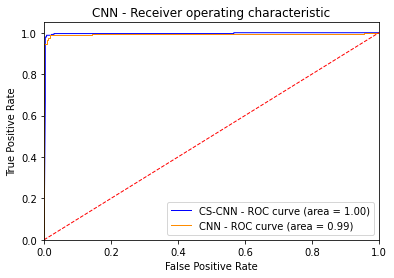

In [32]:
import matplotlib.pyplot as plt
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction_prob)
    roc_auc[i] = auc(fpr[i], tpr[i])


pyplot.figure()
pyplot.plot(fpr[0], tpr[0],color='blue', lw=1, label='CS-CNN - ROC curve (area = %0.2f)' % roc_auc[0])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction_prob1)
    roc_auc[i] = auc(fpr[i], tpr[i])
pyplot.plot(fpr[0], tpr[0],color='darkorange', lw=1, label='CNN - ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('CNN - Receiver operating characteristic')
plt.legend(loc="lower right")
pyplot.show()

In [34]:
m1model = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)
m2model = Model(inputs=model1.input,outputs=model1.get_layer('dense_3').output)

In [35]:
m1_x_train = m1model.predict(x_train,verbose=1)
m1_x_test = m1model.predict(x_test,verbose=1)

m2_x_train = m2model.predict(x_train,verbose=1)
m2_x_test = m2model.predict(x_test,verbose=1)

17/17 [==============================] - 0s 15ms/step


In [36]:
print("Shape of model1 Train and Test DF : ",m1_x_train.shape," : ",m1_x_test.shape)
print("Shape of model2 Train and Test DF : ",m2_x_train.shape," : ",m2_x_test.shape)

Shape of model1 Train and Test DF :  (1194, 1)  :  (513, 1)
Shape of model2 Train and Test DF :  (1194, 1)  :  (513, 1)


In [37]:
def printMetrics(true,pred):
    print("Accuracy : ",accuracy_score(true, pred))
    print("Precision",precision_score(true, pred , average="weighted"))
    print("Recall : ",recall_score(true, pred , average="weighted"))
    print("F1-score : ",f1_score(true, pred, average="weighted"))
    print("Confusion Matrix : ")
    print(confusion_matrix(true, pred))
    print(classification_report(true,pred))

In [38]:
LR = LogisticRegression()
LR.fit(m1_x_train, y_train)
LRprob = LR.predict_proba(m1_x_test)
y_pred = LR.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

LR = LogisticRegression()
LR.fit(m2_x_train, y_train)
CS_LRprob = LR.predict_proba(m2_x_test)
y_pred = LR.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9805068226120858
Precision 0.9807471347604012
Recall :  0.9805068226120858
F1-score :  0.9804920956236746
Confusion Matrix : 
[[268   2]
 [  8 235]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.99      0.97      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.9883040935672515
Precision 0.9884137549689206
Recall :  0.9883040935672515
F1-score :  0.9882985624911682
Confusion Matrix : 
[[269   1]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       270
           1       1.00      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99

In [39]:
RF = RandomForestClassifier()
RF.fit(m1_x_train, y_train)
RFprob = RF.predict_proba(m1_x_test)
y_pred = RF.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

RF = RandomForestClassifier()
RF.fit(m2_x_train, y_train)
CS_RFprob = RF.predict_proba(m2_x_test)
y_pred = RF.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9805068226120858
Precision 0.9805281142813099
Recall :  0.9805068226120858
F1-score :  0.9805025127241268
Confusion Matrix : 
[[266   4]
 [  6 237]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       270
           1       0.98      0.98      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.98635477582846
Precision 0.9864131482552535
Recall :  0.98635477582846
F1-score :  0.9863500933453018
Confusion Matrix : 
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99    

In [40]:
DT = DecisionTreeClassifier()
DT.fit(m1_x_train, y_train)
DTprob = DT.predict_proba(m1_x_test)
y_pred = DT.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

DT = DecisionTreeClassifier()
DT.fit(m2_x_train, y_train)
CS_DTprob = DT.predict_proba(m2_x_test)
y_pred = DT.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9805068226120858
Precision 0.9805281142813099
Recall :  0.9805068226120858
F1-score :  0.9805025127241268
Confusion Matrix : 
[[266   4]
 [  6 237]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       270
           1       0.98      0.98      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.98635477582846
Precision 0.9864131482552535
Recall :  0.98635477582846
F1-score :  0.9863500933453018
Confusion Matrix : 
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99    

In [41]:

KNN = KNeighborsClassifier()
KNN.fit(m1_x_train, y_train)
KNNprob = KNN.predict_proba(m1_x_test)
y_pred = KNN.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

KNN = KNeighborsClassifier()
KNN.fit(m2_x_train, y_train)
CS_KNNprob = KNN.predict_proba(m2_x_test)
y_pred = KNN.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9785575048732943
Precision 0.9787181858389289
Recall :  0.9785575048732943
F1-score :  0.9785444174628143
Confusion Matrix : 
[[267   3]
 [  8 235]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.99      0.97      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.98635477582846
Precision 0.9864131482552535
Recall :  0.98635477582846
F1-score :  0.9863500933453018
Confusion Matrix : 
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99    

In [42]:

GNB = GaussianNB()
GNB.fit(m1_x_train, y_train)
GNBprob = GNB.predict_proba(m1_x_test)
y_pred = GNB.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

GNB = GaussianNB()
GNB.fit(m2_x_train, y_train)
CS_GNBprob = GNB.predict_proba(m2_x_test)
y_pred = GNB.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9805068226120858
Precision 0.9806081492709571
Recall :  0.9805068226120858
F1-score :  0.9804976041519468
Confusion Matrix : 
[[267   3]
 [  7 236]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.99      0.97      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.9902534113060428
Precision 0.990258880405246
Recall :  0.9902534113060428
F1-score :  0.9902523712142562
Confusion Matrix : 
[[268   2]
 [  3 240]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       270
           1       0.99      0.99      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99 

In [43]:
AB = AdaBoostClassifier()
AB.fit(m1_x_train, y_train)
ABprob = AB.predict_proba(m1_x_test)
y_pred = AB.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

AB = AdaBoostClassifier()
AB.fit(m2_x_train, y_train)
CS_ABprob = AB.predict_proba(m2_x_test)
y_pred = AB.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9805068226120858
Precision 0.9805281142813099
Recall :  0.9805068226120858
F1-score :  0.9805025127241268
Confusion Matrix : 
[[266   4]
 [  6 237]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       270
           1       0.98      0.98      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.98635477582846
Precision 0.9864131482552535
Recall :  0.98635477582846
F1-score :  0.9863500933453018
Confusion Matrix : 
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99    

In [44]:
LSVM = svm.SVC(kernel='linear',probability=True)
LSVM.fit(m1_x_train, y_train)
LSVMprob = LSVM.predict_proba(m1_x_test)
y_pred = LSVM.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

LSVM = svm.SVC(kernel='linear',probability=True)
LSVM.fit(m2_x_train, y_train)
CS_LSVMprob = LSVM.predict_proba(m2_x_test)
y_pred = LSVM.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9785575048732943
Precision 0.9787181858389289
Recall :  0.9785575048732943
F1-score :  0.9785444174628143
Confusion Matrix : 
[[267   3]
 [  8 235]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.99      0.97      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.98635477582846
Precision 0.9864131482552535
Recall :  0.98635477582846
F1-score :  0.9863500933453018
Confusion Matrix : 
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99    

In [45]:
RSVM = svm.SVC(kernel='rbf',probability=True)
RSVM.fit(m1_x_train, y_train)
RSVMprob = RSVM.predict_proba(m1_x_test)
y_pred = RSVM.predict(m1_x_test)
print("cost-insensitive")
printMetrics(y_test,y_pred)

RSVM = svm.SVC(kernel='linear',probability=True)
RSVM.fit(m2_x_train, y_train)
CS_RSVMprob = RSVM.predict_proba(m2_x_test)
y_pred = RSVM.predict(m2_x_test)
print("cost-sensitive")
printMetrics(y_test,y_pred)

cost-insensitive
Accuracy :  0.9785575048732943
Precision 0.9787181858389289
Recall :  0.9785575048732943
F1-score :  0.9785444174628143
Confusion Matrix : 
[[267   3]
 [  8 235]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.99      0.97      0.98       243

    accuracy                           0.98       513
   macro avg       0.98      0.98      0.98       513
weighted avg       0.98      0.98      0.98       513

cost-sensitive
Accuracy :  0.98635477582846
Precision 0.9864131482552535
Recall :  0.98635477582846
F1-score :  0.9863500933453018
Confusion Matrix : 
[[268   2]
 [  5 238]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       0.99      0.98      0.99       243

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99    

In [46]:
SMALL_SIZE = 12
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

pyplot.rc('font', size=SMALL_SIZE)          # controls default text sizes
pyplot.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
pyplot.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
pyplot.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
pyplot.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

def rocinfo(pred):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(2):
      fpr[i], tpr[i], _ = roc_curve(y_test, pred)
      roc_auc[i] = auc(fpr[i], tpr[i])
  return fpr,tpr,roc_auc

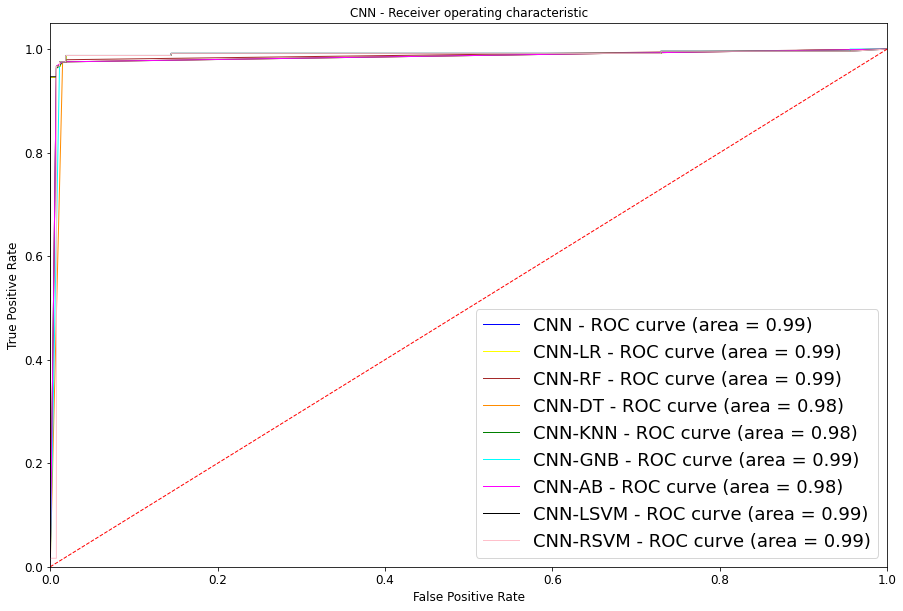

In [47]:
pyplot.figure(figsize=(15,10))

fpr,tpr,roc_auc = rocinfo(prediction_prob1) 
pyplot.plot(fpr[0], tpr[0],color='blue', lw=1, label='CNN - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(LRprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='yellow', lw=1, label='CNN-LR - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(RFprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='brown', lw=1, label='CNN-RF - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(DTprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='darkorange', lw=1, label='CNN-DT - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(KNNprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='green', lw=1, label='CNN-KNN - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(GNBprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='cyan', lw=1, label='CNN-GNB - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(ABprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='magenta', lw=1, label='CNN-AB - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(LSVMprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='black', lw=1, label='CNN-LSVM - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(RSVMprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='pink', lw=1, label='CNN-RSVM - ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('CNN - Receiver operating characteristic')
plt.legend(loc="lower right")
pyplot.show()

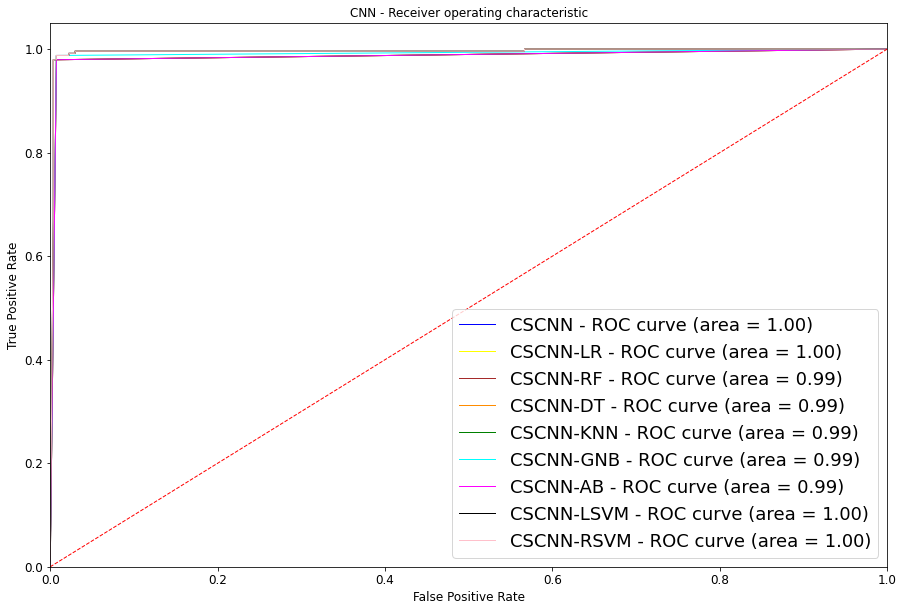

In [48]:
pyplot.figure(figsize=(15,10))

fpr,tpr,roc_auc = rocinfo(prediction_prob) 
pyplot.plot(fpr[0], tpr[0],color='blue', lw=1, label='CSCNN - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_LRprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='yellow', lw=1, label='CSCNN-LR - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_RFprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='brown', lw=1, label='CSCNN-RF - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_DTprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='darkorange', lw=1, label='CSCNN-DT - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_KNNprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='green', lw=1, label='CSCNN-KNN - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_GNBprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='cyan', lw=1, label='CSCNN-GNB - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_ABprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='magenta', lw=1, label='CSCNN-AB - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_LSVMprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='black', lw=1, label='CSCNN-LSVM - ROC curve (area = %0.2f)' % roc_auc[0])

fpr,tpr,roc_auc = rocinfo(CS_RSVMprob[:,1]) 
pyplot.plot(fpr[0], tpr[0],color='pink', lw=1, label='CSCNN-RSVM - ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('CNN - Receiver operating characteristic')
plt.legend(loc="lower right")
pyplot.show()

In [56]:
# !ls "/Dataset/csl"
from google.colab import files
# files.download('/Dataset/csl/checkpoint-0023.hdf5')
files.download('/Dataset/csl/result_logger.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>